# Skorch

简单记录如何使用一个兼容sklearn的包装了pytorch的神经网络库。安装可以使用conda：

```Shell
conda install skorch
```

主要参考官方文档：[skorch documentation](https://skorch.readthedocs.io/en/latest/?badge=latest)

skorch 库的目的本身就是尽可能将pytorch和sklearn来拟合起来使用。它通过提供一个有sklearn接口的pytorch 包装来实现。

skorch没有重复造轮子，如果对sklearn和pytorch都比较熟悉，那么语法都会是熟悉的语法。

此外，skorch简化了训练循环，使许多样板代码过时了。一个简单的net.fit(x,y)就足够了。skorch开箱即用，可处理多种类型的数据，例如PyTorch张量，NumPy数组，Python dict等。如果还有其他数据，也很容易扩展skorch。

下面先看一个例子。

## Quickstart

一个简单的神经网络分类例子 NeuralNetClassifier

In [2]:
import numpy as np
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F

from skorch import NeuralNetClassifier


X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)
X

array([[-0.9658346 , -2.1890705 ,  0.16985609, ..., -0.89645284,
         0.3759244 , -1.0849651 ],
       [-0.454767  ,  4.339768  , -0.48572844, ...,  2.9030426 ,
        -0.9739298 ,  2.1753323 ],
       [ 0.04121372, -2.457531  , -0.27141634, ...,  3.4025245 ,
         5.5681396 ,  0.366057  ],
       ...,
       [ 1.5076263 , -2.0058584 , -0.21547978, ...,  3.68864   ,
        -0.65711164,  1.3987011 ],
       [-1.5917367 , -2.0708432 , -1.9618258 , ...,  1.0849729 ,
         1.1306771 ,  2.101646  ],
       [-1.4027424 ,  4.459072  ,  0.55552185, ...,  2.5708554 ,
         0.5739863 ,  2.4207122 ]], dtype=float32)

In [3]:
y

array([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0,

下面可以看到将pytorch构造的神经网络给到NeuralNetClassifier对象，可以简单地调用sklearn地fit函数来实现训练。

In [4]:
class MyModule(nn.Module):
    def __init__(self, num_units=10, nonlin=F.relu):
        super(MyModule, self).__init__()

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X))
        return X


net = NeuralNetClassifier(
    MyModule,
    max_epochs=10,
    lr=0.1,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

net.fit(X, y)
y_proba = net.predict_proba(X)
y_proba

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7040       0.5050        0.6954  0.1017
      2        0.6908       0.5100        0.6887  0.0349
      3        0.6862       0.5800        0.6813  0.0419


C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


      4        0.6772       0.5950        0.6750  0.0454
      5        0.6673       0.5900        0.6659  0.0439
      6        0.6594       0.6150        0.6572  0.0369
      7        0.6510       0.6400        0.6480  0.0389
      8        0.6378       0.6550        0.6410  0.0339
      9        0.6330       0.6700        0.6324  0.0389
     10        0.6216       0.6800        0.6212  0.0464


array([[0.5332069 , 0.46679318],
       [0.60130286, 0.3986971 ],
       [0.6090455 , 0.3909545 ],
       ...,
       [0.5826988 , 0.4173012 ],
       [0.47568676, 0.5243132 ],
       [0.5778703 , 0.42212975]], dtype=float32)

既然 NeuralNetClassifier 提供了一个sklearn兼容地接口，那么也可以用pipeline，更多关于sklearn pipeline地内容可以参考 2-sklearn-example文件夹下内容。

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


pipe = Pipeline([
    ('scale', StandardScaler()),
    ('net', net),
])

pipe.fit(X, y)
y_proba = pipe.predict_proba(X)
y_proba

Re-initializing module.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6944       0.5500        0.6893  0.0290
      2        0.6897       0.5700        0.6870  0.0439
      3        0.6861       0.6250        0.6848  0.0349
      4        0.6803       0.6150        0.6825  0.0259


C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


      5        0.6795       0.6450        0.6800  0.0329
      6        0.6770       0.6650        0.6774  0.0419
      7        0.6665       0.6550        0.6727  0.0445
      8        0.6671       0.6500        0.6683  0.0374
      9        0.6630       0.6900        0.6636  0.0417
     10        0.6647       0.6750        0.6591  0.0404


C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


array([[0.4878282 , 0.5121718 ],
       [0.53851384, 0.46148616],
       [0.56193954, 0.43806037],
       ...,
       [0.5192269 , 0.48077303],
       [0.5744814 , 0.42551857],
       [0.52439237, 0.47560763]], dtype=float32)

在skorch中可以很容易的执行GridSearch

In [6]:
from sklearn.model_selection import GridSearchCV


params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
    'module__num_units': [10, 20],
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy')

gs.fit(X, y)
print(gs.best_score_, gs.best_params_)

Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7178       0.5000        0.7136  0.0239
      2        0.7167       0.5000        0.7085  0.0239
      3        0.7109       0.5075        0.7049  0.0279
      4        0.7082       0.5075        0.7016  0.0242
      5        0.7032       0.5149        0.6974  0.0249
      6        0.6941       0.5149        0.6937  0.0209


C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


      7        0.6990       0.5224        0.6904  0.0279
      8        0.6888       0.5299        0.6876  0.0299
      9        0.6826       0.5299        0.6849  0.0309
     10        0.6854       0.5299        0.6824  0.0349
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7153       0.5000        0.7193  0.0399
      2        0.7134       0.5000        0.7162  0.0294
      3        0.7141       0.5000        0.7132  0.0309
      4        0.7069       0.5000        0.7102  0.0299


C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


      5        0.7071       0.5000        0.7079  0.0329
      6        0.7011       0.5000        0.7056  0.0324
      7        0.7080       0.5000        0.7031  0.0279
      8        0.6964       0.5075        0.7010  0.0309
      9        0.6959       0.5075        0.6996  0.0284
     10        0.6982       0.5075        0.6977  0.0319
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7070       0.4701        0.7107  0.0219
      2        0.6907       0.4701        0.7097  0.0269
      3        0.7120       0.4851        0.7081  0.0314
      4        0.7020       0.5000        0.7064  0.0319
      5        0.7084       0.5075        0.7051  0.0329

C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app



      6        0.6978       0.5075        0.7038  0.0319
      7        0.7034       0.5075        0.7029  0.0279
      8        0.6937       0.5075        0.7021  0.0389
      9        0.7053       0.5000        0.7011  0.0239
     10        0.6869       0.5000        0.7004  0.0269
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7008       0.5821        0.6797  0.0309
      2        0.7104       0.5970        0.6763  0.0289
      3        0.6926       0.6045        0.6734  0.0339
      4        0.6985       0.6194        0.6706  0.0359


C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


      5        0.6774       0.6343        0.6687  0.0272
      6        0.6989       0.6269        0.6661  0.0199
      7        0.6881       0.6343        0.6637  0.0269
      8        0.6807       0.6194        0.6616  0.0219
      9        0.6774       0.6269        0.6597  0.0269
     10        0.6730       0.6269        0.6582  0.0255
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7284       0.5075        0.7078  0.0283
      2        0.7148       0.5149        0.7059  0.0279
      3        0.7193       0.5224        0.7039  0.0329
      4        0.7084       0.5224        0.7026  0.0303


C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


      5        0.7145       0.5224        0.7007  0.0373
      6        0.7189       0.5299        0.6989  0.0313
      7        0.7128       0.5373        0.6973  0.0305
      8        0.7090       0.5522        0.6959  0.0180
      9        0.7064       0.5373        0.6946  0.0239
     10        0.7096       0.5373        0.6931  0.0293
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6930       0.4552        0.7068  0.0339
      2        0.6976       0.4552        0.7051  0.0299
      3        0.6914       0.4776        0.7039  0.0299
      4        0.6823       0.4851        0.7024  0.0349


C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


      5        0.6727       0.5149        0.7010  0.0319
      6        0.6831       0.5075        0.6994  0.0189
      7        0.6914       0.5149        0.6978  0.0199
      8        0.6718       0.5373        0.6964  0.0239
      9        0.6839       0.5522        0.6949  0.0219
     10        0.6676       0.5597        0.6934  0.0304
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7096       0.5000        0.7082  0.0219
      2        0.7116       0.5000        0.7061  0.0264
      3        0.7075       0.5000        0.7044  0.0329
      4        0.7084       0.5000        0.7025  0.0289
      5        0.7051       0.5000        0.7011  0.0239


C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


      6        0.7005       0.5000        0.6995  0.0299
      7        0.7004       0.5000        0.6978  0.0209
      8        0.6992       0.5000        0.6962  0.0259
      9        0.6946       0.5000        0.6947  0.0275
     10        0.6955       0.5000        0.6936  0.0319
     11        0.6898       0.5000        0.6923  0.0289
     12        0.6951       0.5000        0.6909  0.0330
     13        0.6929       0.5000        0.6899  0.0289
     14        0.6916       0.5000        0.6890  0.0279
     15        0.6907       0.5000        0.6880  0.0239
     16        0.6916       0.5000        0.6871  0.0284
     17        0.6874       0.5000        0.6861  0.0289
     18        0.6868       0.5000        0.6850  0.0279
     19        0.6857       0.4925        0.6842  0.0289
     20        0.6847       0.5000        0.6835  0.0319
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the fol

C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app



      7        0.7162       0.5000        0.7084  0.0274
      8        0.7125       0.5000        0.7066  0.0325
      9        0.7093       0.5000        0.7053  0.0279
     10        0.7130       0.5000        0.7041  0.0239
     11        0.7063       0.5000        0.7029  0.0239
     12        0.7044       0.5000        0.7014  0.0225
     13        0.7052       0.5000        0.7006  0.0319
     14        0.7012       0.5000        0.6997  0.0170
     15        0.6988       0.5000        0.6987  0.0299
     16        0.6985       0.5000        0.6980  0.0229
     17        0.6988       0.5000        0.6974  0.0304
     18        0.6990       0.5000        0.6966  0.0299
     19        0.6953       0.5000        0.6961  0.0289
     20        0.7023       0.5000        0.6955  0.0219
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_units.
Re-initializin

C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app



      6        0.6937       0.5075        0.6981  0.0298
      7        0.6923       0.5075        0.6980  0.0279
      8        0.6883       0.5075        0.6973  0.0219
      9        0.6846       0.5149        0.6970  0.0256
     10        0.6889       0.5149        0.6965  0.0314
     11        0.6912       0.5224        0.6958  0.0479
     12        0.6872       0.5224        0.6955  0.0299
     13        0.6820       0.5149        0.6953  0.0479
     14        0.6800       0.5149        0.6950  0.0699
     15        0.6863       0.5149        0.6947  0.0678
     16        0.6823       0.5224        0.6941  0.0399
     17        0.6883       0.5373        0.6935  0.0319
     18        0.6822       0.5299        0.6936  0.0349
     19        0.6785       0.5224        0.6931  0.0320
     20        0.6865       0.5224        0.6929  0.0385
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the fo

C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


      5        0.6935       0.5149        0.6832  0.0339
      6        0.6829       0.5149        0.6809  0.0459
      7        0.6906       0.5299        0.6792  0.0259
      8        0.6773       0.5448        0.6775  0.0309
      9        0.6853       0.5746        0.6755  0.0339
     10        0.6790       0.5821        0.6737  0.0259
     11        0.6845       0.5970        0.6717  0.0319
     12        0.6714       0.6045        0.6699  0.0269
     13        0.6810       0.6194        0.6681  0.0329
     14        0.6670       0.6269        0.6665  0.0389
     15        0.6653       0.6493        0.6646  0.0299
     16        0.6588       0.6418        0.6630  0.0259
     17        0.6576       0.6418        0.6612  0.0279
     18        0.6600       0.6493        0.6596  0.0289
     19        0.6607       0.6418        0.6580  0.0299
     20        0.6580       0.6343        0.6565  0.0239
Re-initializing module because the following parameters were re-set: num_units.
Re-initi

C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


      6        0.6926       0.5373        0.6823  0.0294
      7        0.6849       0.5299        0.6812  0.0239
      8        0.6771       0.5448        0.6801  0.0339
      9        0.6925       0.5597        0.6791  0.0304
     10        0.6839       0.5597        0.6782  0.0339
     11        0.6792       0.5746        0.6773  0.0319
     12        0.6812       0.5746        0.6763  0.0269
     13        0.6820       0.5746        0.6753  0.0239
     14        0.6707       0.5896        0.6745  0.0269
     15        0.6748       0.6045        0.6739  0.0220
     16        0.6698       0.6194        0.6731  0.0189
     17        0.6689       0.6418        0.6722  0.0229
     18        0.6680       0.6418        0.6713  0.0299
     19        0.6741       0.6418        0.6702  0.0249
     20        0.6670       0.6418        0.6692  0.0239
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the fol

C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app



      6        0.6956       0.4478        0.7039  0.0229
      7        0.7093       0.4552        0.7024  0.0249
      8        0.6933       0.4403        0.7009  0.0284
      9        0.6930       0.4552        0.6997  0.0219
     10        0.6894       0.4851        0.6974  0.0259
     11        0.6894       0.5075        0.6962  0.0229
     12        0.7003       0.5075        0.6947  0.0279
     13        0.6937       0.5075        0.6935  0.0289
     14        0.6903       0.5075        0.6924  0.0249
     15        0.6873       0.5000        0.6915  0.0229
     16        0.6816       0.5000        0.6908  0.0279
     17        0.6814       0.5075        0.6896  0.0229
     18        0.6881       0.5224        0.6886  0.0209
     19        0.6760       0.5224        0.6879  0.0219
     20        0.6825       0.5448        0.6869  0.0289
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the fo

C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app



      6        0.6881       0.5522        0.6846  0.0279
      7        0.6906       0.5672        0.6833  0.0289
      8        0.6879       0.5672        0.6818  0.0229
      9        0.6856       0.5597        0.6806  0.0249
     10        0.6818       0.5821        0.6784  0.0302
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6976       0.4925        0.6997  0.0259
      2        0.7081       0.4776        0.6980  0.0329
      3        0.6858       0.4925        0.6966  0.0269
      4        0.6979       0.5149        0.6948  0.0359
      5        0.6986       0.5299        0.6937  0.0269

C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app



      6        0.6959       0.5224        0.6928  0.0209
      7        0.6927       0.5299        0.6921  0.0299
      8        0.6892       0.5373        0.6911  0.0285
      9        0.6744       0.5000        0.6905  0.0195
     10        0.6889       0.5299        0.6892  0.0209
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7121       0.5075        0.7093  0.0359
      2        0.7133       0.5075        0.7063  0.0349
      3        0.7020       0.5224        0.7032  0.0299
      4        0.6986       0.5149        0.7011  0.0324


C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


      5        0.6993       0.5149        0.6986  0.0319
      6        0.7007       0.5149        0.6962  0.0239
      7        0.6875       0.5149        0.6936  0.0244
      8        0.6912       0.5075        0.6920  0.0219
      9        0.6881       0.5149        0.6901  0.0229
     10        0.6859       0.5224        0.6882  0.0229
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6853       0.5448        0.6798  0.0172
      2        0.6824       0.5522        0.6774  0.0359
      3        0.6843       0.5672        0.6747  0.0215
      4        0.6718       0.6194        0.6718  0.0289
      5        0.6647       0.6119        0.6699  0.0299


C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


      6        0.6677       0.6119        0.6669  0.0319
      7        0.6681       0.5970        0.6644  0.0335
      8        0.6633       0.6045        0.6616  0.0349
      9        0.6628       0.6343        0.6586  0.0309
     10        0.6648       0.6567        0.6559  0.0349
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7141       0.4328        0.7044  0.0269
      2        0.7099       0.4627        0.7003  0.0249
      3        0.6985       0.4701        0.6991  0.0259
      4        0.6953       0.4776        0.6980  0.0220
      5        0.6915       0.4925        0.6961  0.0328


C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


      6        0.6890       0.5075        0.6948  0.0288
      7        0.6887       0.5149        0.6938  0.0339
      8        0.6828       0.5149        0.6928  0.0325
      9        0.6739       0.5149        0.6921  0.0314
     10        0.6793       0.5373        0.6915  0.0359
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7254       0.5075        0.6971  0.0263
      2        0.7236       0.5075        0.6931  0.0209
      3        0.7137       0.5149        0.6897  0.0199
      4        0.6908       0.5373        0.6864  0.0275
      5        0.7043       0.5299        0.6842  0.0249


C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


      6        0.7049       0.5373        0.6826  0.0309
      7        0.7004       0.5672        0.6808  0.0489
      8        0.6851       0.5896        0.6787  0.0718
      9        0.6853       0.6045        0.6774  0.0319
     10        0.6844       0.6119        0.6759  0.0419
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7334       0.5000        0.7345  0.0399
      2        0.7331       0.5000        0.7267  0.0538


C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


      3        0.7212       0.5000        0.7217  0.0439
      4        0.7170       0.5000        0.7166  0.0519
      5        0.7107       0.5000        0.7129  0.0432
      6        0.7147       0.5000        0.7087  0.0239
      7        0.7136       0.5075        0.7057  0.0269
      8        0.7012       0.5000        0.7034  0.0249
      9        0.6991       0.5075        0.7011  0.0269
     10        0.6992       0.5149        0.6982  0.0279
     11        0.6972       0.5149        0.6962  0.0259
     12        0.6926       0.5224        0.6943  0.0274
     13        0.6895       0.5149        0.6929  0.0289
     14        0.6859       0.5000        0.6908  0.0239
     15        0.6826       0.5075        0.6893  0.0229
     16        0.6837       0.5299        0.6876  0.0279
     17        0.6846       0.5373        0.6864  0.0269
     18        0.6858       0.5149        0.6843  0.0294
     19        0.6850       0.5373        0.6827  0.0289
     20        0.6854       0.5

C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


      6        0.6895       0.5299        0.6936  0.0269
      7        0.6898       0.5224        0.6923  0.0339
      8        0.6844       0.5075        0.6907  0.0289
      9        0.6914       0.5299        0.6893  0.0289
     10        0.6851       0.5299        0.6881  0.0199
     11        0.6893       0.5299        0.6861  0.0189
     12        0.6813       0.5299        0.6851  0.0244
     13        0.6844       0.5299        0.6836  0.0208
     14        0.6882       0.5373        0.6819  0.0209
     15        0.6823       0.5299        0.6802  0.0245
     16        0.6860       0.5373        0.6792  0.0160
     17        0.6749       0.5373        0.6779  0.0199
     18        0.6786       0.5373        0.6765  0.0249
     19        0.6657       0.5448        0.6743  0.0225
     20        0.6768       0.5448        0.6733  0.0219
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the fol

C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app



      8        0.6820       0.4851        0.6888  0.0259
      9        0.6834       0.4925        0.6874  0.0209
     10        0.6778       0.4925        0.6862  0.0209
     11        0.6820       0.5000        0.6849  0.0189
     12        0.6734       0.5000        0.6837  0.0209
     13        0.6860       0.5224        0.6826  0.0180
     14        0.6720       0.5224        0.6810  0.0219
     15        0.6712       0.5597        0.6794  0.0209
     16        0.6698       0.5821        0.6774  0.0249
     17        0.6652       0.5970        0.6760  0.0249
     18        0.6622       0.6343        0.6744  0.0269
     19        0.6588       0.6418        0.6732  0.0252
     20        0.6567       0.6269        0.6719  0.0289
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_

C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app



      7        0.6946       0.5149        0.6934  0.0279
      8        0.6890       0.5522        0.6921  0.0229
      9        0.6906       0.5746        0.6907  0.0269
     10        0.6883       0.5896        0.6895  0.0259
     11        0.6906       0.6119        0.6880  0.0219
     12        0.6850       0.6119        0.6867  0.0219
     13        0.6860       0.6194        0.6853  0.0229
     14        0.6819       0.6343        0.6840  0.0308
     15        0.6879       0.6343        0.6830  0.0239
     16        0.6866       0.6493        0.6818  0.0269
     17        0.6829       0.6567        0.6803  0.0257
     18        0.6785       0.6716        0.6787  0.0229
     19        0.6825       0.6567        0.6777  0.0249
     20        0.6794       0.6567        0.6766  0.0269
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the following parameters were re-set: num_units.
Re-initializin

C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


      6        0.6783       0.6343        0.6742  0.0259
      7        0.6723       0.6418        0.6723  0.0199
      8        0.6569       0.6567        0.6700  0.0249
      9        0.6638       0.6642        0.6681  0.0244
     10        0.6542       0.6642        0.6662  0.0209
     11        0.6556       0.6642        0.6643  0.0219
     12        0.6585       0.6716        0.6623  0.0190
     13        0.6495       0.6940        0.6598  0.0229
     14        0.6518       0.7015        0.6569  0.0229
     15        0.6409       0.6866        0.6548  0.0199
     16        0.6460       0.6866        0.6524  0.0239
     17        0.6389       0.6866        0.6508  0.0229
     18        0.6364       0.6866        0.6485  0.0239
     19        0.6378       0.6940        0.6464  0.0239
     20        0.6378       0.7015        0.6436  0.0219
Re-initializing module because the following parameters were re-set: num_units.
Re-initializing optimizer.
Re-initializing module because the fol

C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


      7        0.6986       0.5746        0.6859  0.0309
      8        0.6993       0.5896        0.6827  0.0339
      9        0.6860       0.5597        0.6798  0.0329
     10        0.6890       0.5821        0.6772  0.0279
     11        0.6838       0.5821        0.6751  0.0339
     12        0.6790       0.6269        0.6718  0.0319
     13        0.6793       0.6269        0.6696  0.0299
     14        0.6781       0.6418        0.6671  0.0369
     15        0.6701       0.6567        0.6643  0.0349
     16        0.6635       0.6716        0.6614  0.0349
     17        0.6706       0.6866        0.6588  0.0314
     18        0.6647       0.6940        0.6568  0.0329
     19        0.6607       0.7015        0.6547  0.0319
     20        0.6500       0.7015        0.6521  0.0289
0.705088321854789 {'lr': 0.02, 'max_epochs': 20, 'module__num_units': 20}


## Basic usage

接下来看看sktorch的基本用法。以一个回归器为例。

In [42]:
import torch
from torch import nn
import torch.nn.functional as F

torch.manual_seed(0);

A toy regression task

In [43]:
from sklearn.datasets import make_regression
X_regr, y_regr = make_regression(1000, 20, n_informative=10, random_state=0)
X_regr = X_regr.astype(np.float32)
y_regr = y_regr.astype(np.float32) / 100
y_regr = y_regr.reshape(-1, 1)
X_regr.shape, y_regr.shape, y_regr.min(), y_regr.max()

((1000, 20), (1000, 1), -6.4901485, 6.154505)

定义一个简单的两层神经网络。

In [44]:
class RegressorModule(nn.Module):
    def __init__(
            self,
            num_units=10,
            nonlin=F.relu,
    ):
        super(RegressorModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 1)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = F.relu(self.dense1(X))
        X = self.output(X)
        return X

然后定义和训练神经网络回归器：

In [45]:
from skorch import NeuralNetRegressor
net_regr = NeuralNetRegressor(
    RegressorModule,
    max_epochs=20,
    lr=0.1,
#     device='cuda',  # uncomment this to train with CUDA
)
net_regr.fit(X_regr, y_regr)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        4.6521        3.9025  0.0718
      2        4.2853        3.2140  0.0489
      3        2.4202        0.5702  0.0454
      4        0.4799        0.2762  0.0549
      5        0.2664        0.4691  0.0449
      6        0.3470        0.1310  0.0578
      7        0.1079        0.1244  0.0409
      8        0.0805        0.0744  0.0479
      9        0.0744        0.1681  0.0568
     10        0.1528        0.1326  0.0613
     11        0.1552        0.1704  0.0564
     12        0.1021        0.0694  0.0539
     13        0.0634        0.0530  0.0463
     14        0.0298        0.0342  0.0569
     15        0.0368        0.0375  0.0510
     16        0.0234        0.0326  0.0549
     17        0.0396        0.0398  0.0399
     18        0.0281        0.0368  0.0429
     19        0.0417        0.0334  0.0549
     20        0.0232        0.0294  0.0449


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=RegressorModule(
    (dense0): Linear(in_features=20, out_features=10, bias=True)
    (dense1): Linear(in_features=10, out_features=10, bias=True)
    (output): Linear(in_features=10, out_features=1, bias=True)
  ),
)

然后是执行预测

In [12]:
y_pred = net_regr.predict(X_regr[:5])
y_pred

array([[ 0.24164444],
       [-1.5176816 ],
       [-0.89105034],
       [-0.2990004 ],
       [-0.512405  ]], dtype=float32)

## MNIST with CNN

接下来看看如何在skorch中使用CNN。首先导入并处理数据。

In [13]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [14]:
mnist = fetch_openml('mnist_784', cache=False)

In [15]:
mnist.data.shape

(70000, 784)

In [16]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

X /= 255.0
X.min(), X.max()

(0.0, 1.0)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

X_train.shape, y_train.shape

((52500, 784), (52500,))

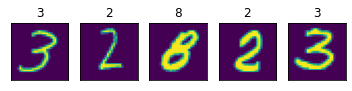

In [18]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)
        
plot_example(X_train, y_train)

接下来用Pytorch 构造神经网络。

In [19]:
import torch
from torch import nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

mnist_dim, hidden_dim, output_dim

(784, 98, 10)

In [24]:
XCnn = X.reshape(-1, 1, 28, 28)
XCnn.shape

(70000, 1, 28, 28)

In [25]:
XCnn_train, XCnn_test, y_train, y_test = train_test_split(XCnn, y, test_size=0.25, random_state=42)
XCnn_train.shape, y_train.shape

((52500, 1, 28, 28), (52500,))

In [26]:
class Cnn(nn.Module):
    def __init__(self, dropout=0.5):
        super(Cnn, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv2_drop = nn.Dropout2d(p=dropout)
        self.fc1 = nn.Linear(1600, 100) # 1600 = number channels * width * height
        self.fc2 = nn.Linear(100, 10)
        self.fc1_drop = nn.Dropout(p=dropout)

    def forward(self, x):
        x = torch.relu(F.max_pool2d(self.conv1(x), 2))
        x = torch.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        
        # flatten over channel, height and width = 1600
        x = x.view(-1, x.size(1) * x.size(2) * x.size(3))
        
        x = torch.relu(self.fc1_drop(self.fc1(x)))
        x = torch.softmax(self.fc2(x), dim=-1)
        return x

In [ ]:
torch.manual_seed(0)

cnn = NeuralNetClassifier(
    Cnn,
    max_epochs=2,
    lr=0.002,
    optimizer=torch.optim.Adam,
    device=device,
)

cnn.fit(XCnn_train, y_train);

接下来预测：

In [ ]:
y_pred_cnn = cnn.predict(XCnn_test)
accuracy_score(y_test, y_pred_cnn)

## Sktorch v.s. PyTorch

还是以MNIST为例，一个标准的sktorch过程。更多内容参考源代码：https://github.com/skorch-dev/skorch/blob/master/examples/benchmarks/mnist.py

## NeuralNet

NeuralNet 及其衍生出的类是用户的主要使用内容。它们包装了PyTorch的Module类，并提供了sklearn接口。定义自己的神经网络的过程就和Pytorch中一样，然后将它和一个pytorch的criterion一起传递给NeuralNet，然后就可以调用fit()函数和predict()函数了。最后形式如下所示：

```Python
class MyModule(torch.nn.Module):
    ...

net = NeuralNet(
    module=MyModule,
    criterion=torch.nn.NLLLoss,
)
net.fit(X, y)
y_pred = net.predict(X_valid)
```

这其中 sktorch做的事情有：

- wraps the PyTorch Module in an sklearn interface
- converts numpy.ndarrays to PyTorch Tensors
- abstracts away the fit loop
- takes care of batching the data

除了前面提到的 module 和 criterion ，还有一些重要的参数和方法：

比如 optimizer ，可以通过它指定pytorch中的优化算法，另外可以通过类似如下形式：

```Python
optimizer__param_groups=[
    ('embedding.*', {'lr': 0.0}),
    ('linear0.bias', {'lr': 1}),
]
```

定义优化函数的参数。

还有 max_epochs，batch_size 定义epoch和batch数目。

train_split 可以执行训练集和验证集的分离。

关于callbacks的更多基本内容可以参考以下环节，总的来说，在 NeuralNet 中，默认的会有几个有用的callbacks，这定义到了  get_default_callbacks() 方法中。除了这些方法，有时候也想提供自己的callback方法，这时候最简单的方法是传递所有自己的callbacks到callbacks参数中，形如：

```Python
net = NeuralNet(
    module=MyModule,
    callbacks=[
        MyCallback1(...),
        MyCallback2(...),
    ],
)
```

更好的办法是给callbacks名称，这样可以避免命名冲突：

```Python
net = NeuralNet(
    module=MyModule,
    callbacks=[
        ('cb1', MyCallback1(...)),
        ('cb2', MyCallback2(...)),
    ],
)
```

这样做还可以更方便的传递参数：

```Python
net.set_params(callbacks__cb1__foo=123, callbacks__cb2__bar=456)
```

另外需要注意的是自定义的 callbacks 会在 default callbacks 之后被调用，因此还是会调用默认的callbacks。不过有一个例外，那就是 PrintLog, 这个默认的callback函数总是会在最后调用。

## Callbacks

Callbacks 提供了灵活的方法来定制 NeuralNet，而不需要继承它。callbacks 通常是和history属性打交道的。想要记录net的行为，要考虑使用net.history。如果想要写自己的callback，需要继承 Callback。一般要注意：

- 应该从基类继承。
- 应至少实现父类提供的一种 on_xxx 方法（比如 on_train_begin(net, X, y) ）。
- 作为参数，方法首先获取NeuralNet实例，并在适当时获取本地数据（例如，当前批次中的数据）。

接下来看例子，这是一个记住在哪一代 validation accuracy 达到某一个值的例子。主要有以下内容：

- 在 __init__ 中设置一个 minimum accuracy
- 在 initialize 中设置 the critical epoch
- 每个epoch 之后，如果还没达到 critical accuracy，就检查是否达到了
- 当训练结束， 发送一个twitter通知训练是否成功

In [53]:
from skorch.callbacks import Callback


def tweet(msg):
    print("~" * 60)
    print("*tweet*", msg, "#skorch #pytorch")
    print("~" * 60)


class AccuracyTweet(Callback):
    def __init__(self, min_accuracy):
        self.min_accuracy = min_accuracy

    def initialize(self):
        self.critical_epoch_ = -1

    def on_epoch_end(self, net, **kwargs):
        if self.critical_epoch_ > -1:
            return
        # look at the validation accuracy of the last epoch
        if net.history[-1, 'valid_acc'] >= self.min_accuracy:
            self.critical_epoch_ = len(net.history)

    def on_train_end(self, net, **kwargs):
        if self.critical_epoch_ < 0:
            msg = "Accuracy never reached {} :(".format(self.min_accuracy)
        else:
            msg = "Accuracy reached {} at epoch {}!!!".format(
                self.min_accuracy, self.critical_epoch_)

        tweet(msg)

现在初始化一个分类器 NeuralNetClassifier ，然后传入callback 参数。

In [54]:
import torch
from torch import nn
import torch.nn.functional as F
torch.manual_seed(0);

class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=10,
            nonlin=F.relu,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin
        self.dropout = dropout

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(dropout)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X

In [55]:
from skorch import NeuralNetClassifier

net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=15,
    lr=0.02,
    warm_start=True,
    callbacks=[AccuracyTweet(min_accuracy=0.7)],
)

In [56]:
import numpy as np
from sklearn.datasets import make_classification
X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X, y = X.astype(np.float32), y.astype(np.int64)
X.shape, y.shape, y.mean()

((1000, 20), (1000,), 0.5)

In [57]:
net.fit(X, y)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6954       0.6000        0.6844  0.0489
      2        0.6802       0.5950        0.6817  0.0309
      3        0.6839       0.6000        0.6792  0.0419
      4        0.6753       0.5900        0.6767  0.0309
      5        0.6769       0.5950        0.6742  0.0314
      6        0.6774       0.6050        0.6720  0.0319
      7        0.6693       0.6250        0.6695  0.0439
      8        0.6694       0.6300        0.6672  0.0329
      9        0.6703       0.6400        0.6652  0.0419
     10        0.6523       0.6550        0.6623  0.0514
     11        0.6641       0.6650        0.6603  0.0439
     12        0.6524       0.6650        0.6582  0.0349
     13        0.6506       0.6700        0.6553  0.0409
     14        0.6489       0.6650        0.6527  0.0459
     15        0.6505       0.6750        0.6502  0.0324
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dense0): Linear(in_features=20, out_features=10, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (dense1): Linear(in_features=10, out_features=10, bias=True)
    (output): Linear(in_features=10, out_features=2, bias=True)
  ),
)

可以看到没有达到0.7，可以再试一次

In [59]:
net.fit(X, y)

     16        0.6473       0.6750        0.6474  0.0289
     17        0.6431       0.6800        0.6443  0.0349
     18        0.6461       0.6900        0.6418  0.0329
     19        0.6430       0.6850        0.6392  0.0409
     20        0.6364       0.6950        0.6366  0.0319
     21        0.6266       0.7000        0.6334  0.0339
     22        0.6316       0.7000        0.6308  0.0469
     23        0.6231       0.7000        0.6277  0.0389
     24        0.6094       0.7000        0.6242  0.0309
     25        0.6250       0.7050        0.6215  0.0429
     26        0.6180       0.7150        0.6187  0.0449
     27        0.6186       0.7150        0.6159  0.0389
     28        0.6144       0.7150        0.6134  0.0441
     29        0.5993       0.7150        0.6100  0.0444
     30        0.5976       0.7150        0.6071  0.0349
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
*tweet* Accuracy reached 0.7 at epoch 21!!! #skorch #pytorch
~~~~~~~~~~~~~~~~~~~~~~~

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dense0): Linear(in_features=20, out_features=10, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (dense1): Linear(in_features=10, out_features=10, bias=True)
    (output): Linear(in_features=10, out_features=2, bias=True)
  ),
)

In [61]:
assert net.history[-1, 'valid_acc'] >= 0.7

如果想要获取最后一个valid_loss可以使用如下代码：

In [62]:
net.history[-1, 'batches', -1, 'valid_loss']

0.5975562930107117

另外，还可以使用 earlystopping 这个callback，如前所述，直接添加到callbacks参数中即可，这里没展示出效果，不过知道使用方法即可，更多参数信息可以参考：https://skorch.readthedocs.io/en/stable/callbacks.html?highlight=earlystop#skorch.callbacks.EarlyStopping

In [74]:
from skorch.callbacks import EarlyStopping
net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=10,
    lr=0.02,
    warm_start=True,
    callbacks=[AccuracyTweet(min_accuracy=0.7),
              EarlyStopping(patience=2)],
)

In [75]:
net.fit(X, y)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7545       0.3750        0.7316  0.0239
      2        0.7453       0.3800        0.7231  0.0329
      3        0.7275       0.3800        0.7174  0.0249
      4        0.7261       0.3850        0.7128  0.0409
      5        0.7185       0.4000        0.7088  0.0339
      6        0.7090       0.3900        0.7064  0.0584
      7        0.7050       0.4000        0.7044  0.0439
      8        0.7019       0.4300        0.7025  0.0409
      9        0.6998       0.4450        0.7009  0.0359
     10        0.6948       0.4650        0.6996  0.0419
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
*tweet* Accuracy never reached 0.7 :( #skorch #pytorch
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dense0): Linear(in_features=20, out_features=10, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (dense1): Linear(in_features=10, out_features=10, bias=True)
    (output): Linear(in_features=10, out_features=2, bias=True)
  ),
)

## Dataset

Dataset 提供了有关数据处理的类和函数。

CVSplit 类负责执行NeuralNet的内部交叉验证，它严格遵守sklearn标准。

CVSplit需要的第一个参数是cv，它的工作原理类似于在sklearn GridSearchCV， cross_val_score()等等中的cv参数。这里补充一个简短说明：

- None：使用默认的3-fold交叉验证。
- 整数：指定的折叠次数(Stratified)KFold，
- float：表示要包含在验证拆分中的数据集的比例（例如0.2，表示20％）。
- object：用作交叉验证生成器的对象。
- 迭代器：生成训练，验证集。

此外，CVSplit 使用一个 stratified 参数来确定是否应进行分层拆分（仅对离散目标有意义），以及一个random_state参数用于交叉验证拆分具有随机成分的情况。

和sklearn的交叉验证的一个区别是skorch仅进行一次拆分。在sklearn中，如果5-flod交叉验证，会对模型的不同折叠组合进行5次训练。而对于神经网络来说，通常并不希望这样，因为训练需要很多时间。因此，**skorch只进行一次拆分**。

注意，CVSplit 在fit函数执行时会自动调用，如后面训练RandomDataset时所示，是有valid_loss的。

如果您希望进行完整的kfold交叉验证，则仍然可以将skorch与sklearn函数结合使用，就像使用其他任何sklearn兼容的估算器一样。只需记住设置 train_split=None，以便将整个数据集用于训练。通常代码形式如下：

```Python
net = NeuralNetClassifier(
    module=MyModule,
    train_split=None,
)

from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(net, X, y, cv=5)
```

在pytorch中 有 Dataset和DataLoader，skorch 默认使用了pytorch的 DataLoader，当调用fit函数时也支持pytorch的Dataset。那么如何在skorch中使用pytorch的Dataset？比如：

In [1]:
import torch.utils.data

class RandomDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.X = torch.randn(128, 10)
        self.Y = torch.randn(128, 10)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def __len__(self):
        return 128

RandomDataset 可以直接传入fit函数

In [2]:
from skorch import NeuralNet
import torch.nn as nn

train_ds = RandomDataset()

class MyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = torch.nn.Linear(10, 10)

    def forward(self, X):
        return self.layer(X)

net = NeuralNet(MyModule, criterion=torch.nn.MSELoss)
net.fit(train_ds)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        1.5074        1.0854  0.0768
      2        1.5047        1.0838  0.0030
      3        1.5021        1.0823  0.0030
      4        1.4995        1.0808  0.0030
      5        1.4969        1.0793  0.0030
      6        1.4944        1.0778  0.0030
      7        1.4918        1.0763  0.0040
      8        1.4893        1.0748  0.0050
      9        1.4867        1.0733  0.0060
     10        1.4842        1.0718  0.0060


C:\Users\hust2\.conda\envs\hydrus\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


<class 'skorch.net.NeuralNet'>[initialized](
  module_=MyModule(
    (layer): Linear(in_features=10, out_features=10, bias=True)
  ),
)

为了支持更多的数据格式，skorch提供了自己的Dataset，它可以兼容：

- numpy.ndarrays
- PyTorch Tensors
- scipy sparse CSR matrices
- pandas DataFrames or Series

数据可以以dict形式传入fit函数，字典的key会被当做forward函数的参数，下面是一个例子，这样可以很简便地处理不同类型地输入。

## Saving and Loading

skorch 提供了很多方法来保存模型。首先，可以使用python的oickle保存模型，这会直接保存整个模型，包括超参数。比如：

```Python
net = NeuralNet(
    module=MyModule,
    criterion=torch.nn.NLLLoss,
)

model = Pipeline([
    ('my-features', get_features()),
    ('net', net),
])
model.fit(X, y)

# saving
with open('some-file.pkl', 'wb') as f:
    pickle.dump(model, f)

# loading
with open('some-file.pkl', 'rb') as f:
    model = pickle.load(f)
```

这尤其在pipeline等时候有用。这种方式的缺点时当你修改了一些代码时，很容易报错。

因此，skorch还提供了第二种保存模型的方法--调用 NeuralNet 中的 save_params() 和 load_params() 方法。这时候保存module的 state_dict，比如module的 weights 和 bias。形如：

```Python
net = NeuralNet(
    module=MyModule,
    criterion=torch.nn.NLLLoss,
)

model = Pipeline([
    ('my-features', get_features()),
    ('net', net),
])
model.fit(X, y)

net.save_params(f_params='some-file.pkl')

new_net = NeuralNet(
    module=MyModule,
    criterion=torch.nn.NLLLoss,
)
new_net.initialize()  # This is important!
new_net.load_params(f_params='some-file.pkl')
```

除了model的参数，history和optimizer state也可以通过包括f_history 和 f_optimizer  关键字到 save_params()和load_params() 来保存。形如：

```Python
net = NeuralNet(
    module=MyModule
    criterion=torch.nn.NLLLoss,
)

net.fit(X, y, epochs=2) # Train for 2 epochs

net.save_params(
    f_params='model.pkl', f_optimizer='opt.pkl', f_history='history.json')

new_net = NeuralNet(
    module=MyModule
    criterion=torch.nn.NLLLoss,
)
new_net.initialize() # This is important!
new_net.load_params(
    f_params='model.pkl', f_optimizer='opt.pkl', f_history='history.json')

new_net.fit(X, y, epochs=2) # Train for another 2 epochs
```

此外，skorch还提供了 Checkpoint, TrainEndCheckpoint, and LoadInitState 等callbacks来处理模型训练中的保存和加载模型。下面是一个例子：

In [76]:
import numpy as np
from sklearn.datasets import make_classification
from torch import nn

X, y = make_classification(1000, 10, n_informative=5, random_state=0)
X = X.astype(np.float32)
y = y.astype(np.int64)

class MyModule(nn.Sequential):
    def __init__(self, num_units=10):
        super().__init__(
            nn.Linear(10, num_units),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(num_units, 10),
            nn.Linear(10, 2),
            nn.Softmax(dim=-1)
        )

然后创建两个不同的checkpoint callbacks并配置它们来保存模型参数，optimizer和history到一个exp1的文件夹中。

In [77]:
# First run

from skorch.callbacks import Checkpoint, TrainEndCheckpoint
from skorch import NeuralNetClassifier

cp = Checkpoint(dirname='exp1')
train_end_cp = TrainEndCheckpoint(dirname='exp1')
net = NeuralNetClassifier(
    MyModule, lr=0.5, callbacks=[cp, train_end_cp]
)

_ = net.fit(X, y)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.5629       0.8750        0.3956     +  0.0409
      2        0.3058       0.9350        0.2583     +  0.0439
      3        0.2270       0.9000        0.2924        0.0339
      4        0.1990       0.7850        0.4077        0.0379
      5        0.2270       0.9550        0.1998     +  0.0374
      6        0.1914       0.9300        0.2043        0.0435
      7        0.1911       0.8300        0.3399        0.0406
      8        0.1974       0.9350        0.2017        0.0364
      9        0.1793       0.9400        0.1932     +  0.0460
     10        0.1783       0.9450        0.1884     +  0.0400


默认的Checkpoint 会观察 valid_loss ，并在改善的时候保存模型。上面的+表示的就是这个。

可以通过LoadInitState来加载checkpoint点来继续训练。

In [78]:
from skorch.callbacks import LoadInitState

cp = Checkpoint(dirname='exp1')
load_state = LoadInitState(cp)
net = NeuralNetClassifier(
    MyModule, lr=0.1, callbacks=[cp, load_state]
)

_ = net.fit(X, y)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
     11        0.1696       0.8650        0.3954     +  0.0269
     12        0.2051       0.9250        0.2246     +  0.0289
     13        0.1607       0.9300        0.1902     +  0.0359
     14        0.1624       0.9350        0.1766     +  0.0389
     15        0.1500       0.9350        0.1866        0.0329
     16        0.1505       0.9400        0.2206        0.0409
     17        0.1766       0.9400        0.1750     +  0.0309
     18        0.1500       0.9100        0.2561        0.0339
     19        0.1539       0.9600        0.1711     +  0.0339
     20        0.1493       0.9500        0.1683     +  0.0439


可以看到，训练是从第11代开始的，也就是第10代结束的时候。创建了一个带 fn_prefix 参数的新的Checkpoint callback，fn_prefix参数的值  'from_train_end_' 是将要保存的文件名的前缀，这样可以确保不会覆盖之前的checkpoint保存文件。

还可以开始新的实验，改变存储的文件夹即可，

In [79]:
cp = Checkpoint(dirname='exp2')
load_state = LoadInitState(cp)
net = NeuralNetClassifier(
    MyModule, lr=0.5,
    callbacks=[cp, load_state],
    module__num_units=20,
)

_ = net.fit(X, y)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.5812       0.8850        0.4392     +  0.1278
      2        0.3166       0.9050        0.2971     +  0.0484
      3        0.2023       0.9250        0.2483     +  0.0399
      4        0.1783       0.9300        0.2178     +  0.0429
      5        0.1546       0.9400        0.2147     +  0.0479
      6        0.1570       0.9350        0.2343        0.0409
      7        0.1537       0.9300        0.2048     +  0.0364
      8        0.1570       0.9450        0.1971     +  0.0404
      9        0.1409       0.9500        0.1923     +  0.0569
     10        0.1389       0.9400        0.1927        0.0409


这会将模型存储到'exp2'目录中。由于这是第一次运行，因此LoadInitState回调不执行任何操作。如果我们再次运行以上脚本，则LoadInitState 回调将从检查点加载模型。

在上面的运行中，最后一个 checkpoint 是在第6个时刻创建的，我们可以加载该 checkpoint 来进行预测：

In [81]:
net = NeuralNetClassifier(
    MyModule, lr=0.5, module__num_units=20,
)
net.initialize()
net.load_params(checkpoint=cp)

y_pred = net.predict(X)
y_pred

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1,

## History

一个 NeuralNet 对象使用了一个History对象来记录训练过程，存储在history 属性中。在很多用例中，history 用来打印每个epoch的训练过程，形如下：

```Python
net.fit(X, y)

# prints
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7111       0.5100        0.6894  0.1345
      2        0.6928       0.5500        0.6803  0.0608
      3        0.6833       0.5650        0.6741  0.0620
      4        0.6763       0.5850        0.6674  0.0594
```

所有信息可以通过 net.history 来获取。保存训练相关数据的最好方式就是通过利用history。

通常History是一系列dicts的list，list中每个item对应每一个epoch，每个dict的key对应每列。因此，比如当想要获取最后一个epoch 的 train_loss 时，应该调用 net.history[-1]['train_loss']。为了使history 信息获取更方便，可以使用这种形式：net.history[-1, 'train_loss'].用逗号来分割。

还有，History 在batches key下存储了每个epoch下的每个batch。所以比如想获取第7个epoch的第3个batch可以使用：net.history[7, 'batches', 3, 'train_loss'].

以下是一些例子，备用：

```Python
# history of a fitted neural net
history = net.history
# get current epoch, a dict
history[-1]
# get train losses from all epochs, a list of floats
history[:, 'train_loss']
# get train and valid losses from all epochs, a list of tuples
history[:, ('train_loss', 'valid_loss')]
# get current batches, a list of dicts
history[-1, 'batches']
# get latest batch, a dict
history[-1, 'batches', -1]
# get train losses from current batch, a list of floats
history[-1, 'batches', :, 'train_loss']
# get train and valid losses from current batch, a list of tuples
history[-1, 'batches', :, ('train_loss', 'valid_loss')]
```

history 就是dicts的list，所以可以写入。skorch 提供了一些函数来使之更容易。比如 new_epoch()函数，它会增加一个新的epoch 字典到list最后。还有，有 new_batch() 可以向当前epoch增加 新的batches。

为了向当前epoch增加新的item，可以使用这种形式：history.record('foo', 123) 。如果想给当前batch增加值：history.record_batch('bar', 456).

以下是一些例子：

```Python
# history of a fitted neural net
history = net.history
# add new epoch row
history.new_epoch()
# add an entry to current epoch
history.record('my-score', 123)
# add a batch row to the current epoch
history.new_batch()
# add an entry to the current batch
history.record_batch('my-batch-score', 456)
# overwrite entry of current batch
history.record_batch('my-batch-score', 789)
```